<a href="https://colab.research.google.com/github/park-geun-hyeong/Kaggle_project/blob/main/cats_vs_dogs2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


In [2]:
path='/content/drive/MyDrive/Kaggle/kaggle_cats_dogs/'

In [4]:
submission=pd.read_csv(path+'sampleSubmission.csv')

In [5]:
submission

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
12495,12496,0
12496,12497,0
12497,12498,0
12498,12499,0


In [6]:
FAST_RUN=False
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
CHANNEL=3
IMAGE_SHAPE=(IMAGE_WIDTH,IMAGE_HEIGHT)


## - cat and dog image 확인


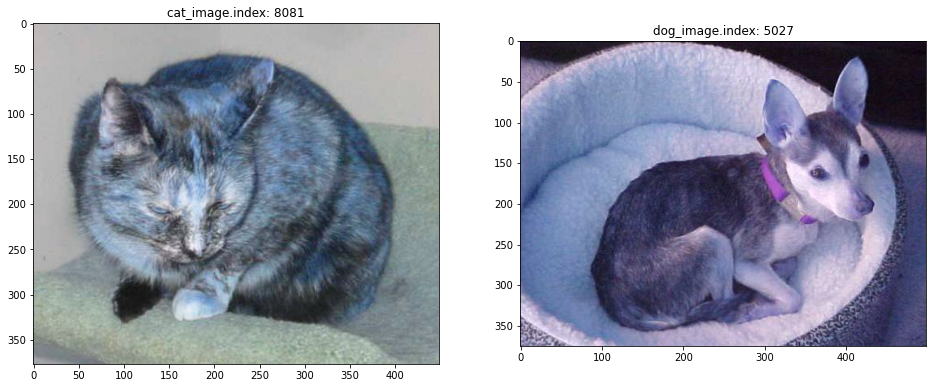

In [36]:
import cv2

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
a=np.random.randint(12499)
b=np.random.randint(12499)
image1 = cv2.imread(path+'train/cat.'+str(a)+'.jpg')
image2 = cv2.imread(path+'train/dog.'+str(b)+'.jpg')
ax1.imshow(image1)
ax2.imshow(image2)

ax1.set_title("cat_image.index: {}".format(a))
ax2.set_title("dog_image.index: {}".format(b))
plt.show()



In [37]:
print(image1.shape)
print(image2.shape)

(377, 449, 3)
(375, 499, 3)


## 학습을 위한 새로운 DataFrame만들기


In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import os 
from tqdm import tqdm

In [44]:
filenames = os.listdir(path+'train') #os.listdir method는 지정된 경로의 모든 파일이름을 리스트 형태로 반환한다.

categories=[]

for filename in tqdm(filenames):
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)


100%|██████████| 25000/25000 [00:00<00:00, 1367594.85it/s]


In [48]:
df=pd.DataFrame({"filenames":filenames,"category":categories})

In [50]:
df.shape

(25000, 2)

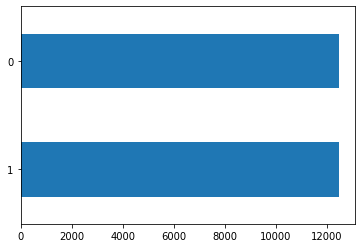

In [52]:
df['category'].value_counts().plot.barh()

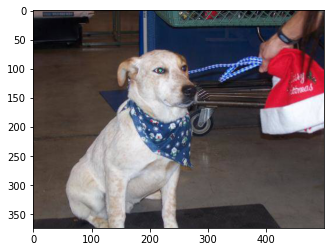

In [62]:
sample =np.random.choice(filenames) # filenames를 이용하여 새롭게 이미지 출력해보기 

img=load_img(path+'train/'+sample)
plt.imshow(img)

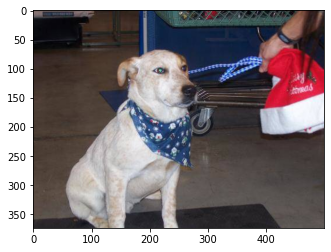

In [65]:
img1= cv2.imread(path+'train/'+sample)
img_rgb=cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) #opencv를 통해서 읽어올경우 BGR로 출력되기때문에, cv2.cvtColor을 사용하여 BGR2RGB를 적용해주어야 원래의 사진이 출려된다.(matplotlib에서 출력하려면)
plt.imshow(img_rgb)
plt.show()

## Model 생성 
- 6개의 Conv2D layer + 512개의 Dense layers + Dropout 0.2 + 마지막 출력은 sigmoid 함수로

In [66]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential

In [71]:
model= Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=(128,128,3),activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), padding='same',activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(96, (3,3), padding='same',activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(96, (3,3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        2

In [74]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint #callbacks 설정 

In [75]:
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max',verbose=1, save_best_only=True)
lrr=ReduceLROnPlateau(monital='val_acc',patience=2, verbose=1, factor=0.5, min_lr=0.0001)

In [110]:
df['category']=df['category'].replace({0:'cat',1:'dog'})

In [116]:
df_cat = df[df['category']=='cat'].iloc[:1000,:]  #25000장의 사진들을 다 학습하려니까 시간이 너~~무 오래걸려서 cat,dog사진 1000씩만 추출하여 학습
df_dog = df[df['category']=='dog'].iloc[:1000,:]

In [118]:
df_cat.shape, df_dog.shape

((1000, 2), (1000, 2))

In [120]:
df_new = pd.concat([df_cat,df_dog],axis=0)

In [121]:
df_new

,filenames,category
0,cat.954.jpg,cat
1,cat.9574.jpg,cat
2,cat.956.jpg,cat
3,cat.9549.jpg,cat
4,cat.9583.jpg,cat
...,...,...
13495,dog.897.jpg,dog
13496,dog.8972.jpg,dog
13497,dog.8949.jpg,dog
13498,dog.8982.jpg,dog


## Train, Validation dataset 나누기

In [77]:
from sklearn.model_selection import train_test_split

In [124]:
train_df,val_df=train_test_split(df_new, test_size=0.2, random_state=42)

train_df.shape,val_df.shape

((1600, 2), (400, 2))

In [126]:
train_df['category'].value_counts()

cat    801
dog    799
Name: category, dtype: int64

In [127]:
val_df['category'].value_counts()

dog    201
cat    199
Name: category, dtype: int64

In [128]:
train_df

,filenames,category
968,cat.8786.jpg,cat
240,cat.9781.jpg,cat
819,cat.9518.jpg,cat
692,cat.9402.jpg,cat
420,cat.9937.jpg,cat
...,...,...
12550,dog.9787.jpg,dog
12714,dog.9957.jpg,dog
860,cat.9509.jpg,cat
12959,dog.9312.jpg,dog


In [129]:
val_df

,filenames,category
13360,dog.8855.jpg,dog
353,cat.993.jpg,cat
12753,dog.9922.jpg,dog
905,cat.9565.jpg,cat
12709,dog.9944.jpg,dog
...,...,...
965,cat.8799.jpg,cat
12704,dog.9904.jpg,dog
13239,dog.9542.jpg,dog
261,cat.9805.jpg,cat


In [130]:
train_df = train_df.reset_index(drop=True) #train,validation data index초기화
val_df = val_df.reset_index(drop=True) 

In [131]:
total_train = train_df.shape[0]
total_val =  val_df.shape[0]
batch_size=15

## ImageDataGenerator 메쏘드를 사용하여 train,validation data tensor화 시키기

In [132]:
train_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1 ) #데이터 확장

In [133]:
train_generator = train_datagen.flow_from_dataframe(train_df, path+'train/',x_col='filenames',y_col='category', target_size=IMAGE_SHAPE, class_mode='categorical', batch_size=batch_size )

Found 1600 validated image filenames belonging to 2 classes.


In [134]:
val_datagen=ImageDataGenerator(rescale=1./255)
val_generator=val_datagen.flow_from_dataframe(val_df,path+'train/', x_col='filenames',y_col='category', target_size=IMAGE_SHAPE, class_mode='categorical', batch_size=batch_size)

Found 400 validated image filenames belonging to 2 classes.


In [135]:
example_df = train_df.sample(n=1).reset_index(drop=True)  #ImageDataGenerator을 사용해 확장된 이미지 살펴보기 
example_df  

,filenames,category
0,cat.9997.jpg,cat


In [136]:
example_generator = train_datagen.flow_from_dataframe(example_df, path+'train/', x_col='filenames',y_col='category', target_size=IMAGE_SHAPE, class_mode='categorical' )

Found 1 validated image filenames belonging to 1 classes.


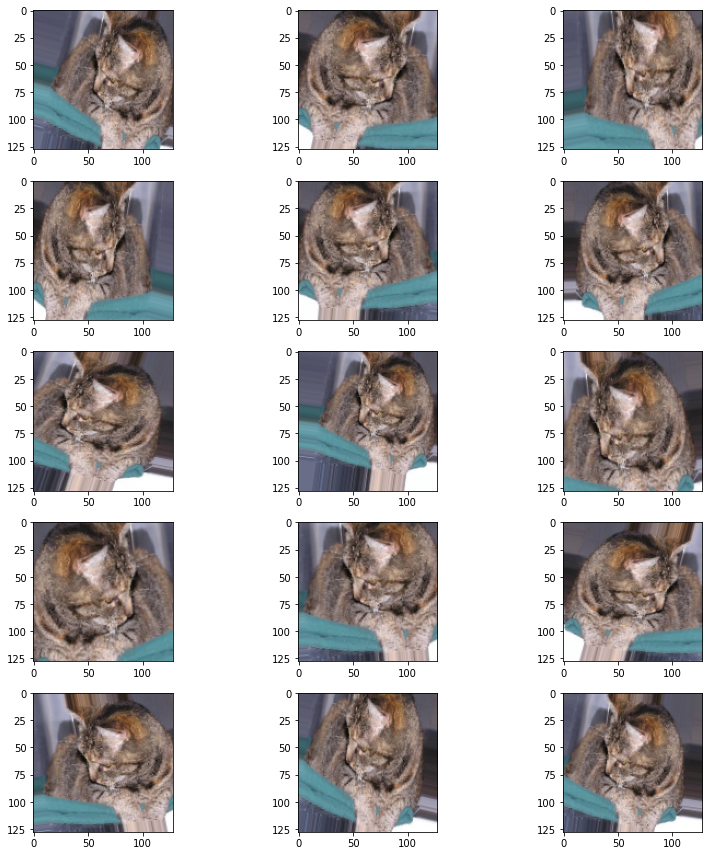

In [137]:
plt.figure(figsize=(12,12))

for i in range(0,15):
    plt.subplot(5,3,i+1)
    for x_batch, y_batch in example_generator:
        image=x_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()        


## 학습 시작

In [138]:
epochs = 3 if FAST_RUN else 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [139]:
history = model.fit_generator(train_generator, epochs=epochs, verbose=1, callbacks=[es,mc,lrr], validation_data=val_generator, validation_steps=total_val//batch_size, steps_per_epoch = total_train//batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
106/106 [==============================] - 426s 4s/step - loss: 0.6902 - acc: 0.6300 - val_loss: 1.8310 - val_acc: 0.5462

Epoch 00001: val_acc improved from -inf to 0.54615, saving model to best_model.h5
Epoch 2/30
106/106 [==============================] - 202s 2s/step - loss: 0.6080 - acc: 0.6871 - val_loss: 0.7058 - val_acc: 0.6641

Epoch 00002: val_acc improved from 0.54615 to 0.66410, saving model to best_model.h5
Epoch 3/30
106/106 [==============================] - 202s 2s/step - loss: 0.6047 - acc: 0.7014 - val_loss: 0.9418 - val_acc: 0.5641

Epoch 00003: val_acc did not improve from 0.66410
Epoch 4/30
106/106 [==============================] - 202s 2s/step - loss: 0.5952 - acc: 0.6752 - val_loss: 0.7729 - val_acc: 0.6103

Epoch 00004: val_acc did not improve from 0.66410

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
106/106 [==============================] - 202s 2s/step - loss: 0.5508 - acc: 0.7091 - val_loss: 0.6497 -

In [140]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.h5") #modelcheckpoint에 저장되었던 best_model 불러오기

## train,validation data 사이의 loss와 acc 시각화 해보기


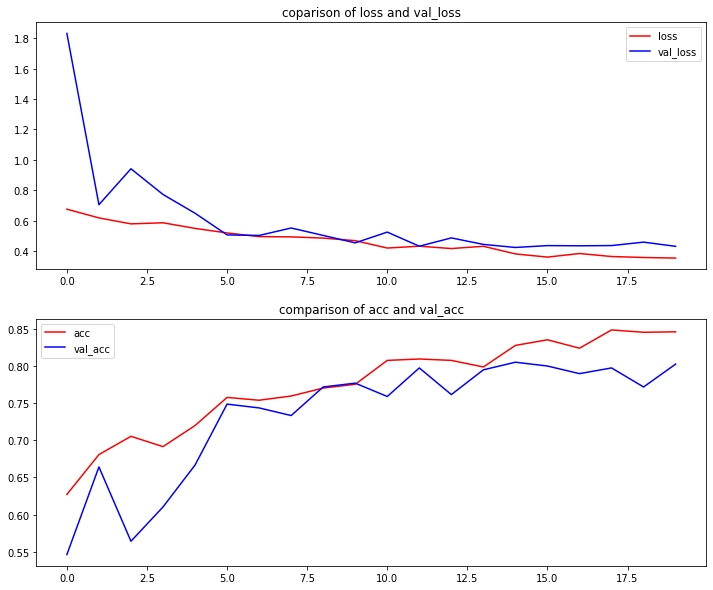

In [142]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,10))

ax1.plot(history.history['loss'],color='red')
ax1.plot(history.history['val_loss'],color='blue')
ax1.set_title("coparison of loss and val_loss")
ax1.legend(['loss','val_loss'], loc='upper right')

ax2.plot(history.history['acc'],color='red')
ax2.plot(history.history['val_acc'],color='blue')
ax2.set_title('comparison of acc and val_acc')
ax2.legend(['acc','val_acc'],loc='upper left')

plt.show()

In [143]:
test_filenames=os.listdir(path+'test1/')

test_df = pd.DataFrame({'filenames':test_filenames})

nb_sample = test_df.shape[0]

In [145]:
test_df

,filenames
0,12046.jpg
1,12053.jpg
2,12052.jpg
3,12031.jpg
4,12027.jpg
...,...
12495,86.jpg
12496,71.jpg
12497,97.jpg
12498,78.jpg


In [147]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df, path+'test1/', x_col='filenames', y_col=None, class_mode=None, target_size=IMAGE_SHAPE, batch_size=batch_size, shuffle=False )

Found 12500 validated image filenames.


In [148]:
pred = best_model.predict_generator(test_generator, steps = np.ceil(nb_sample//batch_size))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [152]:
pred.shape

(12495, 2)

In [157]:
pred

array([[0.36876708, 0.61969024],
       [0.9502504 , 0.04757014],
       [0.00841257, 0.9941689 ],
       ...,
       [0.03339344, 0.962008  ],
       [0.93667537, 0.06054404],
       [0.78980976, 0.2042109 ]], dtype=float32)

In [158]:
a=[[0.4,0.6],[0.4,0.6],[0.4,0.6],[0.6,0.4],[0.6,0.4]]

In [171]:
type(pred),type(a)

(numpy.ndarray, numpy.ndarray)

In [172]:
predict=np.vstack([pred,a])

In [175]:
test_df['category']=np.argmax(predict, axis=-1)

In [176]:
test_df

,filenames,category
0,12046.jpg,1
1,12053.jpg,0
2,12052.jpg,1
3,12031.jpg,0
4,12027.jpg,0
...,...,...
12495,86.jpg,1
12496,71.jpg,1
12497,97.jpg,1
12498,78.jpg,0


In [178]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [179]:
test_df

,filenames,category
0,12046.jpg,dog
1,12053.jpg,cat
2,12052.jpg,dog
3,12031.jpg,cat
4,12027.jpg,cat
...,...,...
12495,86.jpg,dog
12496,71.jpg,dog
12497,97.jpg,dog
12498,78.jpg,cat


In [180]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [182]:
test_df

,filenames,category
0,12046.jpg,1
1,12053.jpg,0
2,12052.jpg,1
3,12031.jpg,0
4,12027.jpg,0
...,...,...
12495,86.jpg,1
12496,71.jpg,1
12497,97.jpg,1
12498,78.jpg,0


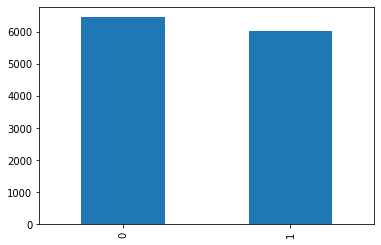

In [183]:
test_df['category'].value_counts().plot.bar()

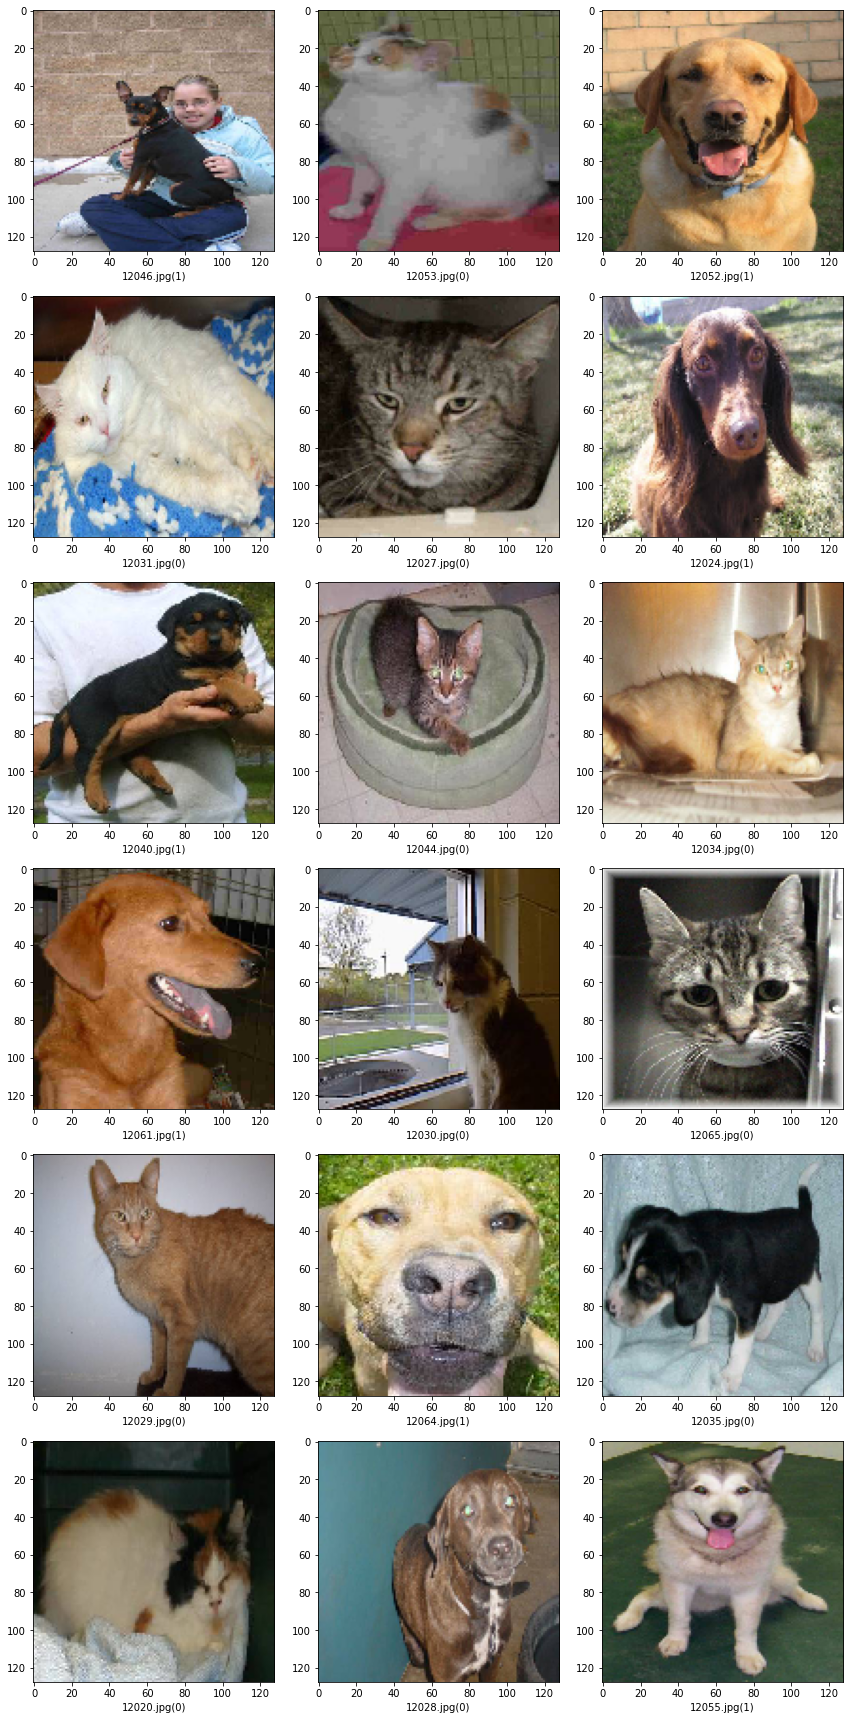

In [185]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filenames']
    category = row['category']
    img = load_img(path+'test1/'+filename, target_size=IMAGE_SHAPE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [187]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filenames'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)


In [192]:
submission_df

,id,label
0,12046,1
1,12053,0
2,12052,1
3,12031,0
4,12027,0
...,...,...
12495,86,1
12496,71,1
12497,97,1
12498,78,0


In [200]:
submission_df.to_csv("cat_dogs_pred.csv",index=False)